<a href="https://colab.research.google.com/github/danbernstein/parkingdirty/blob/master/image_classification/py/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initiate Co-Lab GPU


In [0]:
# Confirm TensorFlow can see the GPU
# Select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).
import tensorflow as tf # for running on tensorflow
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Modules

In [0]:
# load modules
import os # for accessing project file structure
import requests # for downloading and loading data from the internet
import zipfile # for unzipping zip files 

import numpy.random 
from matplotlib import pyplot # for plotting results

# build CNN using tf.keras
from keras import models # for building CNN (deep learning)
from keras import layers # for building fully connected network
from keras import losses
from keras import optimizers

Using TensorFlow backend.


# Data Set-Up

## Download and Extract Data

In [0]:
# download and read in data
zip_address = 'http://parkingdirty.com/BlockedBikeLaneTrainingSingleCam.zip'

import requests, zipfile, io
r = requests.get(zip_address)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall() 

In [0]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [0]:
list_files(zip_address)

## Data Processing (Organizing, Labeling, and Splitting)

In [0]:
# append the label at front, and assign to object
imgs_blocked = list(map('blocked/{0}'.format, os.listdir('blocked')))
imgs_notblocked = list(map('notblocked/{0}'.format, os.listdir('notblocked')))

# shuffle data
numpy.random.shuffle(imgs_blocked)
numpy.random.shuffle(imgs_notblocked)

print("number of blocked images: ", len(imgs_blocked))
print("number of not blocked images: ", len(imgs_notblocked))
print("ratio of classes: ", len(imgs_blocked)/len(imgs_notblocked))

number of blocked images:  2186
number of not blocked images:  1656
ratio of classes:  1.320048309178744


In [0]:
# separate into training (contains training and validation), and test set
training_set = imgs_blocked[:int(round(0.8*len(imgs_blocked)))] + imgs_notblocked[:int(round(0.8*len(imgs_notblocked)))]
print(len(training_set))

test_set = imgs_blocked[int(round(0.8*len(imgs_blocked))):] + imgs_notblocked[int(round(0.8*len(imgs_notblocked))):]
print(len(test_set))

del imgs_blocked
del imgs_notblocked

3074
768


## Image Processing and Resizing

In [0]:
# read and resize images, also store as X, Y with X as image array and Y as label
import cv2

img_arrays = [] # images
img_labels = [] # labels

def read_resize_label_image(img, x_dim, y_dim):
    
  img_orig = cv2.imread(img)
 # img_orig = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
  img_arrays = cv2.resize(img_orig, dsize=(x_dim, y_dim), interpolation=cv2.INTER_CUBIC)
  
 # if the image file name contains "not" then assigned 0, otherwise 1, so 1 is blocked, 0 is notblocked
  if img.find("not") is not -1:
      img_labels = 0
  else:
      img_labels = 1
      
  del img_orig
   
    
  return img_arrays, img_labels


In [0]:
training_arrays, training_labels = zip(*[(read_resize_label_image(i, 300, 300)) for i in training_set])

del training_set

In [0]:
test_arrays, test_labels = zip(*[(read_resize_label_image(i, 300, 300)) for i in test_set])

del test_set

In [0]:
import pandas
print("training: ", pandas.Series(training_labels).value_counts())
print("test: ", pandas.Series(test_labels).value_counts())


training:  1    1749
0    1325
dtype: int64
test:  1    437
0    331
dtype: int64


## **Very Crucial Step: Converting X and Y to arrays**

In [0]:
import numpy as np

X_train_array = np.array(training_arrays)
Y_train_labels = np.array(training_labels)

del training_arrays
del training_labels

X_test_array = np.array(test_arrays)
Y_test_labels = np.array(test_labels)

del test_arrays
del test_labels

NameError: ignored

## Create Validation Set

In [0]:
# separate training data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_train_array, Y_train_labels, test_size = 0.2, 
                                                   shuffle = True)

# confirm the size of the datasets
print("training images: ", len(X_train))
print("training labels: ", len(Y_train))
print("validation images: ", len(X_test))
print("validation labels: ", len(Y_test))

training images:  2459
training labels:  2459
validation images:  615
validation labels:  615


#  Basic Model

In [0]:
print("training: ", pandas.Series(Y_train).value_counts(1))
print("test: ", pandas.Series(Y_test).value_counts(1))

training:  1    0.568117
0    0.431883
dtype: float64
test:  1    0.572358
0    0.427642
dtype: float64


In [0]:
from keras import preprocessing

train_datagen_basic = preprocessing.image.ImageDataGenerator(
                                    rescale=1./255   #Scale the image between 0 and 1
                                    )

val_datagen_basic = preprocessing.image.ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:
#Create the image generators
train_generator_basic = train_datagen_basic.flow(X_train, Y_train, batch_size=64)

val_generator_basic = val_datagen_basic.flow(X_test, Y_test, batch_size=64)

In [0]:
# basic model 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

## Compiler Includes Optimizer, and Learning Rate (LR), and Metrics

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 128)       147584    
__________

## Run the Basic Model

In [0]:
batch_size = 64
epochs = 20

history_basic = model.fit_generator(train_datagen_basic.flow(X_train, Y_train, batch_size=64),
                                    validation_data = val_datagen_basic.flow(X_test, Y_test, batch_size=64),
                                    steps_per_epoch = X_train.shape[0] // batch_size,
                                    validation_steps = X_test.shape[0] // batch_size,
                                    epochs = epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
38/38 [==============================] - 22s 580ms/step - loss: 0.6703 - acc: 0.5966 - val_loss: 0.6371 - val_acc: 0.6649
Epoch 2/20
38/38 [==============================] - 16s 428ms/step - loss: 0.5900 - acc: 0.7075 - val_loss: 0.6135 - val_acc: 0.6697
Epoch 3/20
38/38 [==============================] - 14s 381ms/step - loss: 0.5242 - acc: 0.7541 - val_loss: 0.5902 - val_acc: 0.6878
Epoch 4/20
38/38 [==============================] - 15s 382ms/step - loss: 0.4766 - acc: 0.7802 - val_loss: 0.5539 - val_acc: 0.7368
Epoch 5/20
38/38 [==============================] - 14s 380ms/step - loss: 0.4391 - acc: 0.7940 - val_loss: 0.4856 - val_acc: 0.7568
Epoch 6/20
38/38 [==============================] - 15s 383ms/step - loss: 0.4093 - acc: 0.8267 - val_loss: 0.5141 - val_acc: 0.7877
Epoch 7/20
38/38 [==============================] - 14s 381ms/step - loss: 0.3834 - acc: 0.8345 - val_loss: 0.4712 - val_acc: 0.7677
Epoch 8/20
38/38 [===

In [0]:
#history_basic.__dict__

## Model Diagnostics

Test loss: 2.099729667107264
Test accuracy: 0.8671875


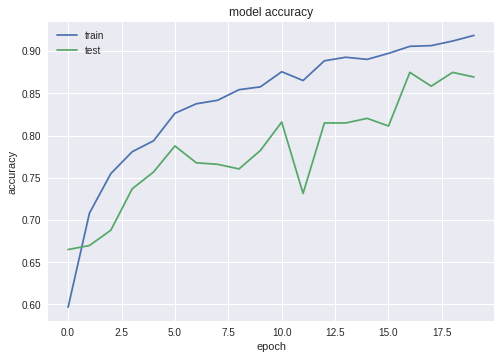

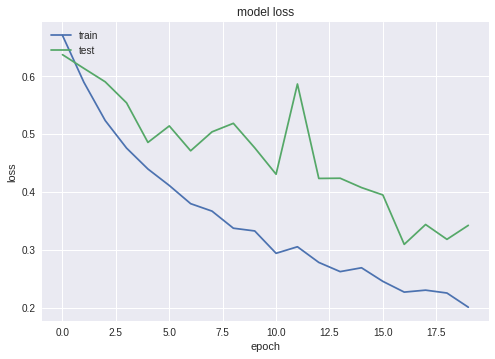

In [0]:
# evaluate model performance

score_basic = model.evaluate(X_test_array, Y_test_labels, verbose=0)
print('Test loss:', score_basic[0])
print('Test accuracy:', score_basic[1])

pyplot.plot(history_basic.history['acc'])
pyplot.plot(history_basic.history['val_acc'])
#pyplot.plot(history_basic.history['test_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.savefig('./plot_acc' + ".jpg")
pyplot.show()


# there is a large gap (0.18) btw training and validation accuracy, so it is probably overfitting the training data


pyplot.plot(history_basic.history['loss'])
pyplot.plot(history_basic.history['val_loss'])
#pyplot.plot(history_basic.history['test_acc'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.savefig('./plot_loss' + ".jpg")
pyplot.show()

